In [0]:
# Copyright 2018 The TensorFlow GAN Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF-GAN Tutorial

Tutorial authors: joelshor@, westbrook@

## Colab Prelims


### Steps to run this notebook

This notebook should be run in Colaboratory. If you are viewing this from GitHub, follow the GitHub instructions. If you are viewing this from Colaboratory, you should skip to the Colaboratory instructions.

#### Steps from GitHub

1. Navigate your web brower to the main Colaboratory website: https://colab.research.google.com.
1. Click the `GitHub` tab.
1. In the field marked `Enter a GitHub URL or search by organization or user`, put in the URL of this notebook in GitHub and click the magnifying glass icon next to it.
1. Run the notebook in colaboratory by following the instructions below.

#### Steps from Colaboratory

This colab will run much faster on GPU. To use a Google Cloud
GPU:

1. Go to `Runtime > Change runtime type`.
1. Click `Hardware accelerator`.
1. Select `GPU` and click `Save`.
1. Click `Connect` in the upper right corner and select `Connect to hosted runtime`.

In [2]:
# Check that imports for the rest of the file work.
import tensorflow as tf
!pip install tensorflow-gan
import tensorflow_gan as tfgan
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
# Allow matplotlib images to render immediately.
%matplotlib inline
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # Disable noisy outputs.

## Overview

This colab will walk you through the basics of using [TF-GAN](https://github.com/tensorflow/gan) to define, train, and evaluate Generative Adversarial Networks (GANs). We describe the library's core features as well as some extra features. This colab assumes a familiarity with TensorFlow's Python API. For more on TensorFlow, please see [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

## Learning objectives

In this Colab, you will learn how to:
*   Use TF-GAN Estimators to quickly train a GAN

## Unconditional MNIST with GANEstimator

This exercise uses TF-GAN's GANEstimator and the MNIST dataset to create a GAN for generating fake handwritten digits.

### MNIST

The [MNIST dataset](https://wikipedia.org/wiki/MNIST_database) contains tens of thousands of images of handwritten digits. We'll use these images to train a GAN to generate fake images of handwritten digits. This task is small enough that you'll be able to train the GAN in a matter of minutes.

### GANEstimator

TensorFlow's Estimator API that makes it easy to train models. TF-GAN offers `GANEstimator`, an Estimator for training GANs.

### Input Pipeline

We set up our input pipeline by defining an `input_fn`. in the "Train and Eval Loop" section below we pass this function to our GANEstimator's `train` method to initiate training.  The `input_fn`:

1.  Generates the random inputs for the generator.
2.  Uses `tensorflow_datasets` to retrieve the MNIST data.
3.  Uses the tf.data API to format the data.

In [0]:
import tensorflow_datasets as tfds
import tensorflow as tf

def input_fn(mode, params):
  assert 'batch_size' in params
  assert 'noise_dims' in params
  bs = params['batch_size']
  nd = params['noise_dims']
  split = 'train' if mode == tf.estimator.ModeKeys.TRAIN else 'test'
  shuffle = (mode == tf.estimator.ModeKeys.TRAIN)
  just_noise = (mode == tf.estimator.ModeKeys.PREDICT)
  
  noise_ds = (tf.data.Dataset.from_tensors(0).repeat()
              .map(lambda _: tf.compat.v1.random_normal([bs, nd])))
  
  if just_noise:
    return noise_ds

  def _preprocess(element):
    # Map [0, 255] to [-1, 1].
    images = (tf.cast(element['image'], tf.float32) - 127.5) / 127.5
    return images

  images_ds = (tfds.load('mnist', split=split)
               .map(_preprocess)
               .cache()
               .repeat())
  if shuffle:
    images_ds = images_ds.shuffle(
        buffer_size=10000, reshuffle_each_iteration=True)
  images_ds = (images_ds.batch(bs, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))

  return tf.data.Dataset.zip((noise_ds, images_ds))

Download the data and sanity check the inputs.

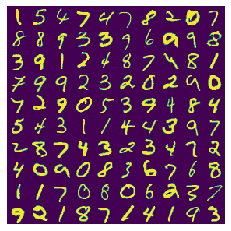

In [4]:
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import numpy as np

params = {'batch_size': 100, 'noise_dims':64}
with tf.Graph().as_default():
  ds = input_fn(tf.compat.v1.estimator.ModeKeys.TRAIN, params)
  numpy_imgs = next(tfds.as_numpy(ds))[1]
img_grid = tfgan.eval.python_image_grid(numpy_imgs, grid_shape=(10, 10))
plt.axis('off')
plt.imshow(np.squeeze(img_grid))
plt.show()

### Neural Network Architecture

To build our GAN we need two separate networks:

*  A generator that takes input noise and outputs generated MNIST digits
*  A discriminator that takes images and outputs a probability of being real or fake

We define functions that build these networks. In the GANEstimator section below we pass the builder functions to the `GANEstimator` constructor. `GANEstimator` handles hooking the generator and discriminator together into the GAN. 


In [0]:
def _dense(inputs, units, l2_weight=2.5e-5):
  return tf.compat.v1.layers.dense(
      inputs, units, None,
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight)
  )
def _batch_norm(inputs, is_training):
  return tf.compat.v1.layers.batch_normalization(
      inputs, momentum=0.999, epsilon=0.001, training=is_training)

def _deconv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tf.compat.v1.layers.conv2d_transpose(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride], 
      activation=tf.compat.v1.nn.relu, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

def _conv2d(inputs, filters, kernel_size, stride, l2_weight):
  return tf.compat.v1.layers.conv2d(
      inputs, filters, [kernel_size, kernel_size], strides=[stride, stride], 
      activation=None, padding='same',
      kernel_initializer=tf.keras.initializers.glorot_uniform,
      kernel_regularizer=tf.keras.regularizers.l2(l=l2_weight),
      bias_regularizer=tf.keras.regularizers.l2(l=l2_weight))

In [0]:
def unconditional_generator(noise, mode, weight_decay=2.5e-5):
  """Generator to produce unconditional MNIST images."""
  is_training = (mode == tf.compat.v1.estimator.ModeKeys.TRAIN)
  
  net = _dense(noise, 1024, weight_decay)
  net = _batch_norm(net, is_training)
  net = tf.compat.v1.nn.relu(net)
  
  net = _dense(net, 7 * 7 * 256, weight_decay)
  net = _batch_norm(net, is_training)
  net = tf.compat.v1.nn.relu(net)
  
  net = tf.reshape(net, [-1, 7, 7, 256])
  net = _deconv2d(net, 64, 4, 2, weight_decay)
  net = _deconv2d(net, 64, 4, 2, weight_decay)
  # Make sure that generator output is in the same range as `inputs`
  # ie [-1, 1].
  net = _conv2d(net, 1, 4, 1, 0.0)
  net = tf.tanh(net)

  return net

In [0]:
_leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)

def unconditional_discriminator(img, unused_conditioning, mode, weight_decay=2.5e-5):
  del unused_conditioning
  is_training = (mode == tf.estimator.ModeKeys.TRAIN)
  
  net = _conv2d(img, 64, 4, 2, weight_decay)
  net = _leaky_relu(net)
  
  net = _conv2d(net, 128, 4, 2, weight_decay)
  net = _leaky_relu(net)
  
  net = tf.compat.v1.layers.flatten(net)
  
  net = _dense(net, 1024, weight_decay)
  net = _batch_norm(net, is_training)
  net = _leaky_relu(net)
  
  net = _dense(net, 1, weight_decay)

  return net

### Evaluating Generative Models, and evaluating GANs


TF-GAN provides some standard methods of evaluating generative models. In this example, we measure:

*  Inception Score: called `mnist_score` below.
*  Frechet Inception Distance

We apply a pre-trained classifier to both the real data and the generated data calculate the *Inception Score*.  The Inception Score is designed to measure both quality and diversity. See [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) by Salimans et al for more information about the Inception Score.

*Frechet Inception Distance* measures how close the generated image distribution is to the real image distribution.  See [GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium](https://arxiv.org/abs/1706.08500) by Heusel et al for more information about the Frechet Inception distance.

In [0]:
from tensorflow_gan.examples.mnist import util as eval_util
import os

def get_eval_metric_ops_fn(gan_model):
  real_data_logits = tf.reduce_mean(gan_model.discriminator_real_outputs)
  gen_data_logits = tf.reduce_mean(gan_model.discriminator_gen_outputs)
  real_mnist_score = eval_util.mnist_score(gan_model.real_data)
  generated_mnist_score = eval_util.mnist_score(gan_model.generated_data)
  frechet_distance = eval_util.mnist_frechet_distance(
      gan_model.real_data, gan_model.generated_data)
  return {
      'real_data_logits': tf.metrics.mean(real_data_logits),
      'gen_data_logits': tf.metrics.mean(gen_data_logits),
      'real_mnist_score': tf.metrics.mean(real_mnist_score),
      'mnist_score': tf.metrics.mean(generated_mnist_score),
      'frechet_distance': tf.metrics.mean(frechet_distance),
  }

### GANEstimator

The `GANEstimator` assembles and manages the pieces of the whole GAN model. The `GANEstimator` constructor takes the following compoonents for both the generator and discriminator:

*  Network builder functions: we defined these in the "Neural Network Architecture" section above.
*  Loss functions: here we use the wasserstein loss for both.
*  Optimizers: here we use `tf.train.AdamOptimizer` for both generator and discriminator training.

In [0]:
train_batch_size = 32 #@param
noise_dimensions = 64 #@param
generator_lr = 0.001 #@param
discriminator_lr = 0.0002 #@param

def gen_opt():
  gstep = tf.compat.v1.train.get_or_create_global_step()
  base_lr = generator_lr
  # Halve the learning rate at 1000 steps.
  lr = tf.cond(gstep < 1000, lambda: base_lr, lambda: base_lr / 2.0)
  return tf.compat.v1.train.AdamOptimizer(lr, 0.5)

gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn=unconditional_generator,
    discriminator_fn=unconditional_discriminator,
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    params={'batch_size': train_batch_size, 'noise_dims': noise_dimensions},
    generator_optimizer=gen_opt,
    discriminator_optimizer=tf.compat.v1.train.AdamOptimizer(discriminator_lr, 0.5),
    get_eval_metric_ops_fn=get_eval_metric_ops_fn)

### Train and eval loop

The `GANEstimator`'s `train()` method initiates GAN training, including the alternating generator and discriminator training phases.

The loop in the code below calls `train()` repeatedly in order to periodically display generator output and evaluation results. But note that the code below does not manage the alternation between discriminator and generator: that's all handled automatically by `train()`.

Time since start: 0.45 min
Trained from step 0 to 500 in 18.49 steps / sec
Average discriminator output on Real: -9.86  Fake: -8.81
Inception Score: 6.09 / 8.35  Frechet Distance: 79.25


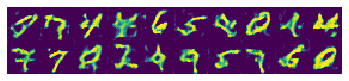

Time since start: 0.99 min
Trained from step 500 to 1000 in 19.99 steps / sec
Average discriminator output on Real: -7.35  Fake: -7.74
Inception Score: 6.86 / 8.35  Frechet Distance: 64.99


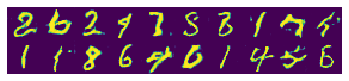

Time since start: 1.52 min
Trained from step 1000 to 1500 in 19.95 steps / sec
Average discriminator output on Real: -11.58  Fake: -12.06
Inception Score: 6.93 / 8.35  Frechet Distance: 64.94


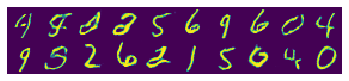

Time since start: 2.07 min
Trained from step 1500 to 2000 in 18.49 steps / sec
Average discriminator output on Real: -10.50  Fake: -11.63
Inception Score: 7.27 / 8.35  Frechet Distance: 55.55


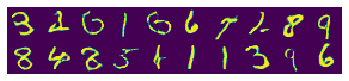

Time since start: 2.66 min
Trained from step 2000 to 2500 in 17.79 steps / sec
Average discriminator output on Real: 5.02  Fake: 0.77
Inception Score: 7.28 / 8.35  Frechet Distance: 54.92


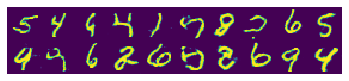

Time since start: 3.24 min
Trained from step 2500 to 3000 in 17.90 steps / sec
Average discriminator output on Real: 17.78  Fake: 16.35
Inception Score: 7.29 / 8.35  Frechet Distance: 56.14


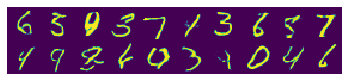

Time since start: 3.82 min
Trained from step 3000 to 3500 in 17.81 steps / sec
Average discriminator output on Real: 73.79  Fake: 66.71
Inception Score: 7.61 / 8.35  Frechet Distance: 52.60


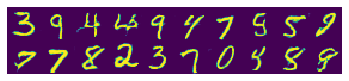

Time since start: 4.40 min
Trained from step 3500 to 4000 in 18.09 steps / sec
Average discriminator output on Real: 37.14  Fake: 19.75
Inception Score: 7.36 / 8.35  Frechet Distance: 59.37


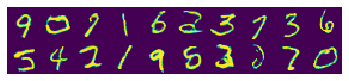

Time since start: 5.00 min
Trained from step 4000 to 4500 in 17.20 steps / sec
Average discriminator output on Real: 129.79  Fake: 126.22
Inception Score: 7.42 / 8.35  Frechet Distance: 58.30


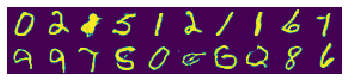

Time since start: 5.61 min
Trained from step 4500 to 5000 in 17.14 steps / sec
Average discriminator output on Real: 34.10  Fake: 17.50
Inception Score: 7.31 / 8.35  Frechet Distance: 60.51


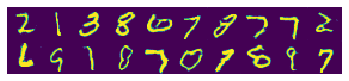

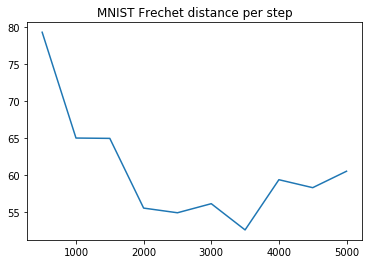

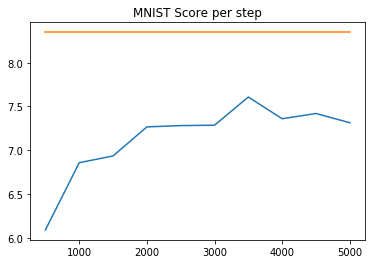

In [10]:
# Disable noisy output.
tf.autograph.set_verbosity(0, False)

import time
steps_per_eval = 500 #@param
max_train_steps = 5000 #@param
batches_for_eval_metrics = 100 #@param

# Used to track metrics.
steps = []
real_logits, fake_logits = [], []
real_mnist_scores, mnist_scores, frechet_distances = [], [], []

cur_step = 0
start_time = time.time()
while cur_step < max_train_steps:
  next_step = min(cur_step + steps_per_eval, max_train_steps)

  start = time.time()
  gan_estimator.train(input_fn, max_steps=next_step)
  steps_taken = next_step - cur_step
  time_taken = time.time() - start
  print('Time since start: %.2f min' % ((time.time() - start_time) / 60.0))
  print('Trained from step %i to %i in %.2f steps / sec' % (
      cur_step, next_step, steps_taken / time_taken))
  cur_step = next_step
  
  # Calculate some metrics.
  metrics = gan_estimator.evaluate(input_fn, steps=batches_for_eval_metrics)
  steps.append(cur_step)
  real_logits.append(metrics['real_data_logits'])
  fake_logits.append(metrics['gen_data_logits'])
  real_mnist_scores.append(metrics['real_mnist_score'])
  mnist_scores.append(metrics['mnist_score'])
  frechet_distances.append(metrics['frechet_distance'])
  print('Average discriminator output on Real: %.2f  Fake: %.2f' % (
      real_logits[-1], fake_logits[-1]))
  print('Inception Score: %.2f / %.2f  Frechet Distance: %.2f' % (
      mnist_scores[-1], real_mnist_scores[-1], frechet_distances[-1]))
  
  # Vizualize some images.
  iterator = gan_estimator.predict(
      input_fn, hooks=[tf.train.StopAtStepHook(num_steps=21)])
  try:
    imgs = np.array([next(iterator) for _ in range(20)])
  except StopIteration:
    pass
  tiled = tfgan.eval.python_image_grid(imgs, grid_shape=(2, 10))
  plt.axis('off')
  plt.imshow(np.squeeze(tiled))
  plt.show()
  
  
# Plot the metrics vs step.
plt.title('MNIST Frechet distance per step')
plt.plot(steps, frechet_distances)
plt.figure()
plt.title('MNIST Score per step')
plt.plot(steps, mnist_scores)
plt.plot(steps, real_mnist_scores)
plt.show()

### Next steps

Try [this colab notebook](https://github.com/tensorflow/gan) to train a GAN on Google's Cloud TPU use TF-GAN.


